#  Hybrid Example - Tau Hybrid Solver

The hybrid solver is capable of solving models which include both discrete and continuous species.  In order for a species to be considered continuously, it must be included in a rate_rule, along with it's rate of change.  This species can then be considered in reactions by explicitly declaring the species as part of the reaction's propensity function.

### Imports

In [10]:
import sys, os
import matplotlib.pyplot as plt
import numpy
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../GillesPy2')))
import gillespy2
from gillespy2 import TauHybridSolver

### Instantiate Model
Model requires species, parameters, and reactions.  rate_rules can also be added to model a species continuously

In [36]:
class SimpleHybridModel(gillespy2.Model):
     def __init__(self, parameter_values=None, init_v=1):
            #initialize Model
            gillespy2.Model.__init__(self, name="Simple_Hybrid_Model")

            
            #Species
            A = gillespy2.Species(name='A', initial_value=0)
            '''
            Setting the continuous species.mode to "continuous" will prevent this species from being
            considered discretely, and allows it to be modeled continuously with a rate rule.
            '''
            V = gillespy2.Species(name='V', initial_value=init_v, mode='continuous')

            self.add_species([A, V])
            
            #parameters
            rate1 = gillespy2.Parameter(name='rate1', expression= 20.0)
            rate2 = gillespy2.Parameter(name='rate2', expression= 10.0)
            
            #rate_rules
            '''We create a rate rule with two arguments.  The first is the species
            to be governed by the rate rule.  In this case, we choose our
            previously declared continuous species "V" and give it the rate function of
            cos(t).
            '''
            rate_rule1 = gillespy2.RateRule(variable="V", formula="cos(t)", name="rr1")
            self.add_parameter([rate1, rate2])
            self.add_rate_rule([rate_rule1])
            
            #reactions
            '''
            Because we want to use our continuous species "V" in the propensity function
            for r1, we associate a custom propensity function, rather than a simple rate.
            Here we can simply use the rate times our continuous species "V".'''
            r1 = gillespy2.Reaction(name="r1",reactants={}, products={A:1},
                   propensity_function="rate1 * V")
            
            r2 = gillespy2.Reaction(name="r2",reactants={A:1}, products={},
                    rate=rate2)
            
            self.add_reaction([r1, r2])
            
            self.timespan(gillespy2.TimeSpan.linspace(t=20, num_points=201))

In [37]:
model = SimpleHybridModel()

### Run Model and Plot

In [41]:
%time results = model.run(solver=TauHybridSolver)

CPU times: user 280 ms, sys: 7.96 ms, total: 288 ms
Wall time: 284 ms


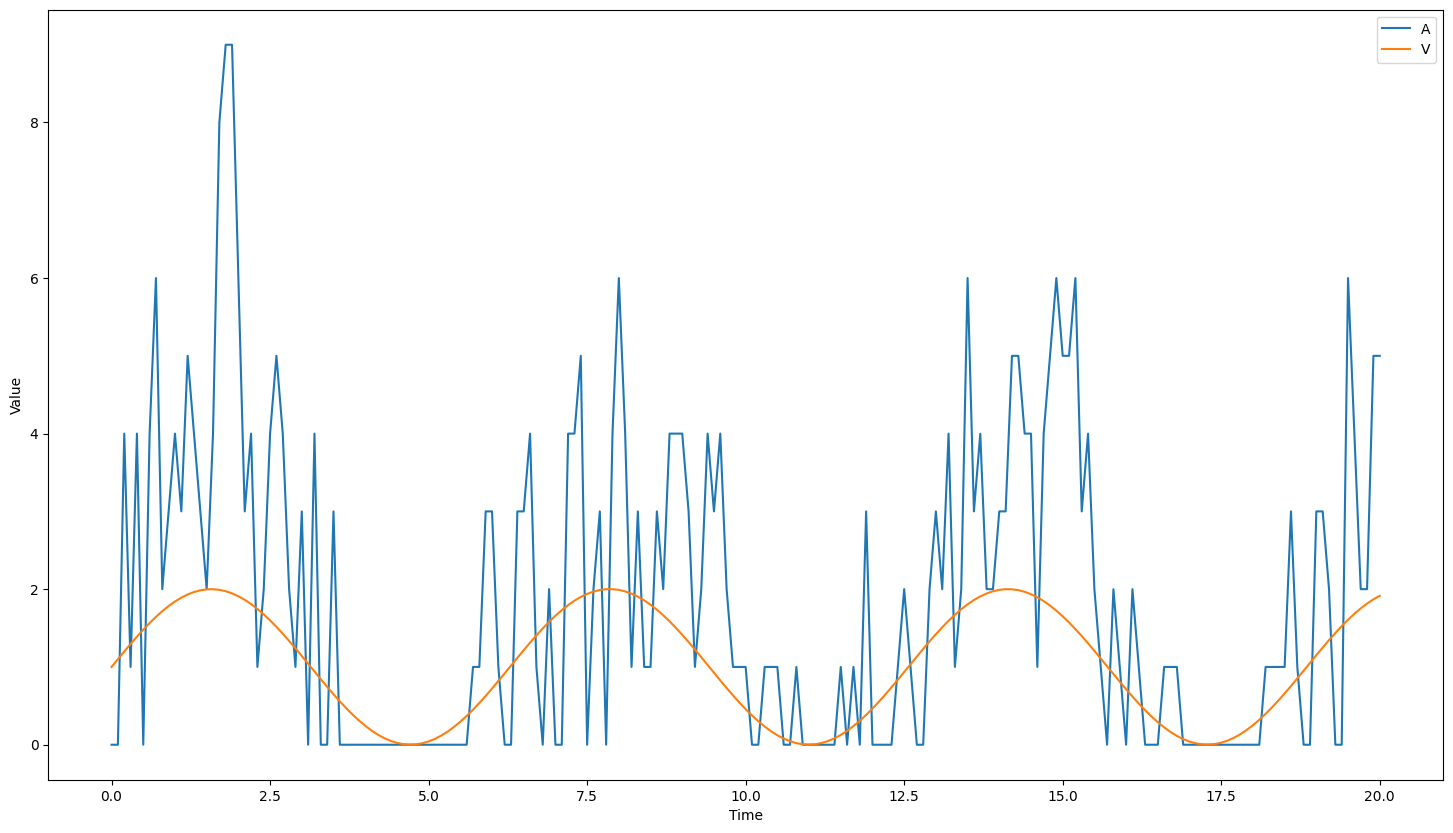

In [42]:
results.plot()


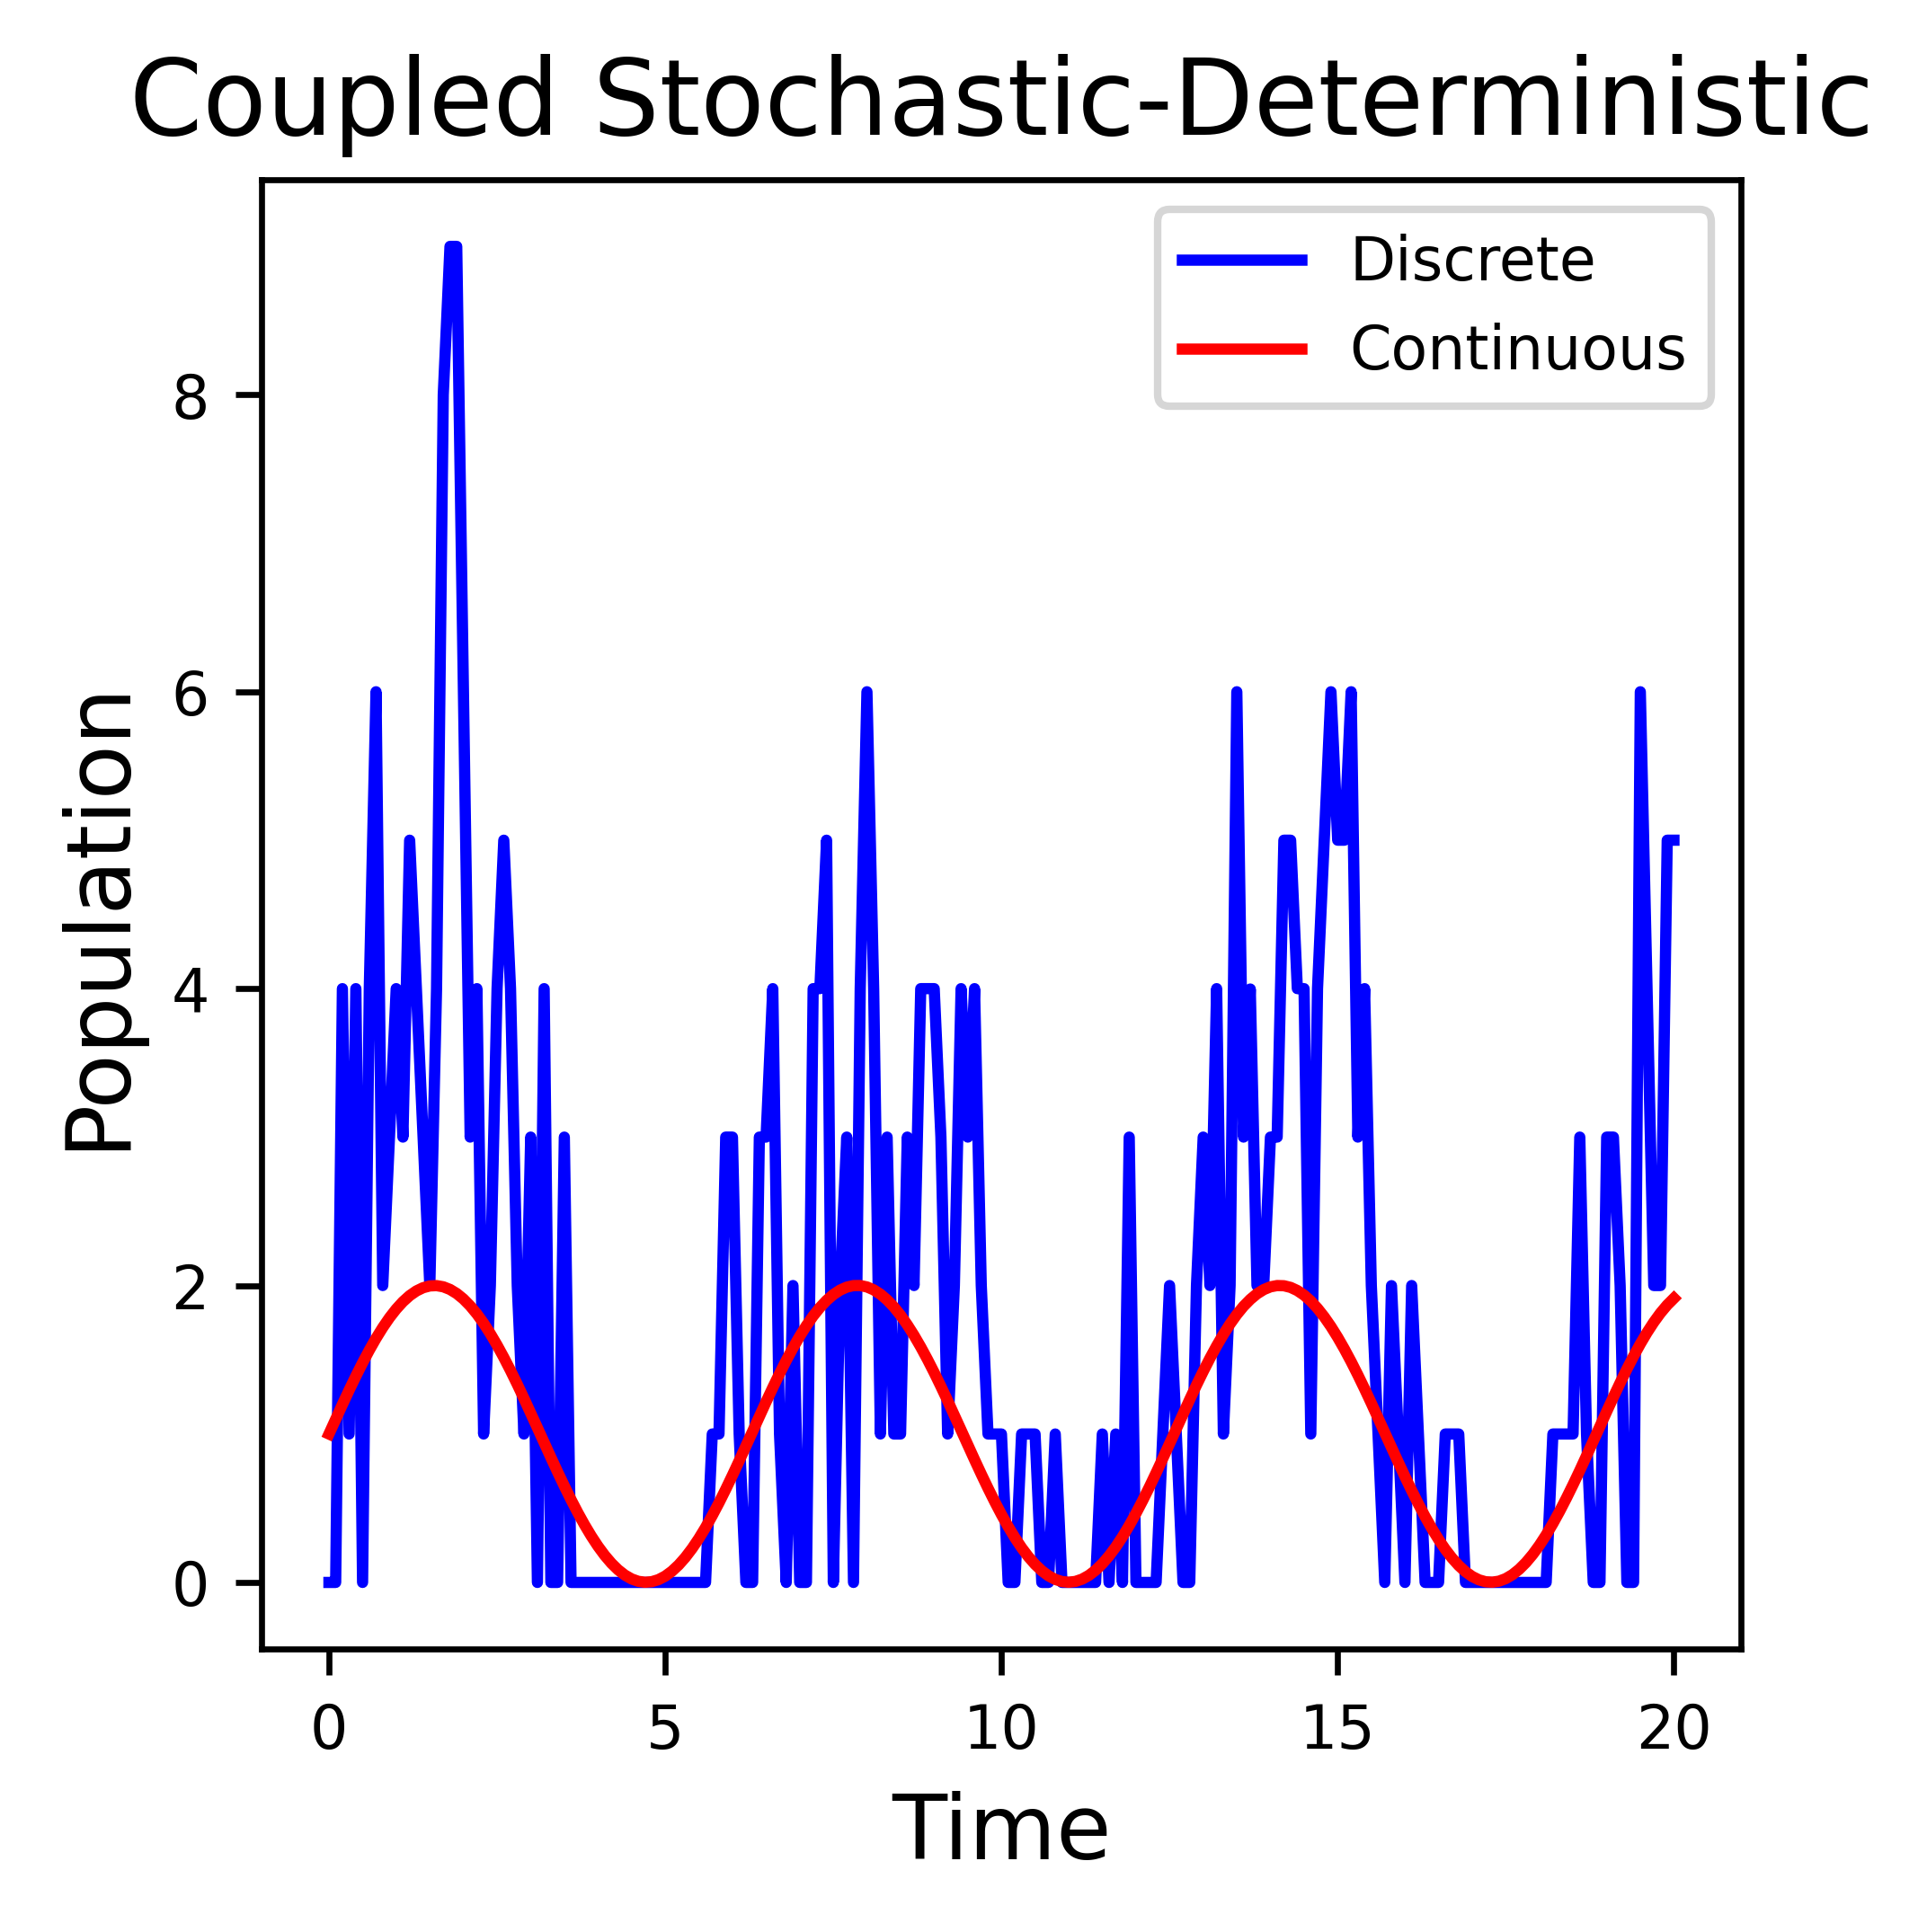

In [55]:
fig = plt.figure(figsize=(3.54,3.54), dpi=600)
plt.plot(results['time'], results['A'], '-b', label='Discrete')
plt.plot(results['time'], results['V'], '-r', label='Continuous')
plt.title("Coupled Stochastic-Deterministic", fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Population', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best', fontsize=8)
plt.savefig('../images/Hybrid_coupling.png', bbox_inches='tight')

# Hybrid Switching  
  
The Hybrid Switching solver is designed to allow a model's species to be represented dynamically as either continuous or stochastic throughout the simulation.  This solver will represent a reaction channel deterministically at high populations in order to favor performance, and will automatically switch to a stochastic representation at lower populations.  This allows for substantial run-time improvements over the SSA, minimizing the loss of stochastic accuracy.  
  
There is no special setup for the standard case of using this switching mechanism, however for cases where a particular species should always be represented as 'stochastic' or always represented as 'continuous,' the GillesPy2.species can be constructed with kwarg 'mode' locking that into place.  
  
  
**mode='dynamic'(default) - allows for hybrid switching  
mode='continuous' - forces a species to be modeled continuously/deterministically  
mode='discrete' - forces a species to be modeled discretely/stochastically**  
  
Ex:  
A = GillesPy2.Species(name='A', initial_value=400, mode='continuous')

In [6]:
class AutomaticSwitchExample(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Automatic Switch Example")
            
            #parameters
            k1 = gillespy2.Parameter(name='k1', expression= 3e-4)
            k2 = gillespy2.Parameter(name='k2', expression= .5e-2)
            k3 = gillespy2.Parameter(name='k3', expression = 2e-1)
            self.add_parameter([k1,k2,k3])
            
            #Species
            A = gillespy2.Species(name='A', initial_value=400)
            B = gillespy2.Species(name='B', initial_value=10000)
            C = gillespy2.Species(name='C', initial_value=10000)
            self.add_species([A, B, C])
            
            #reactions
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={B:1,C:1},
                   rate=k1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={B:1}, products={},
                    rate=k2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={C:1}, products={A:1},
                    rate=k3)

            self.add_reaction([r1,r2,r3])
            self.timespan(numpy.linspace(0,600,601))

In [7]:
model = AutomaticSwitchExample()

In [8]:
%time tau_hybrid_results = model.run(solver=TauHybridSolver)

CPU times: user 27.7 s, sys: 621 µs, total: 27.7 s
Wall time: 50 s


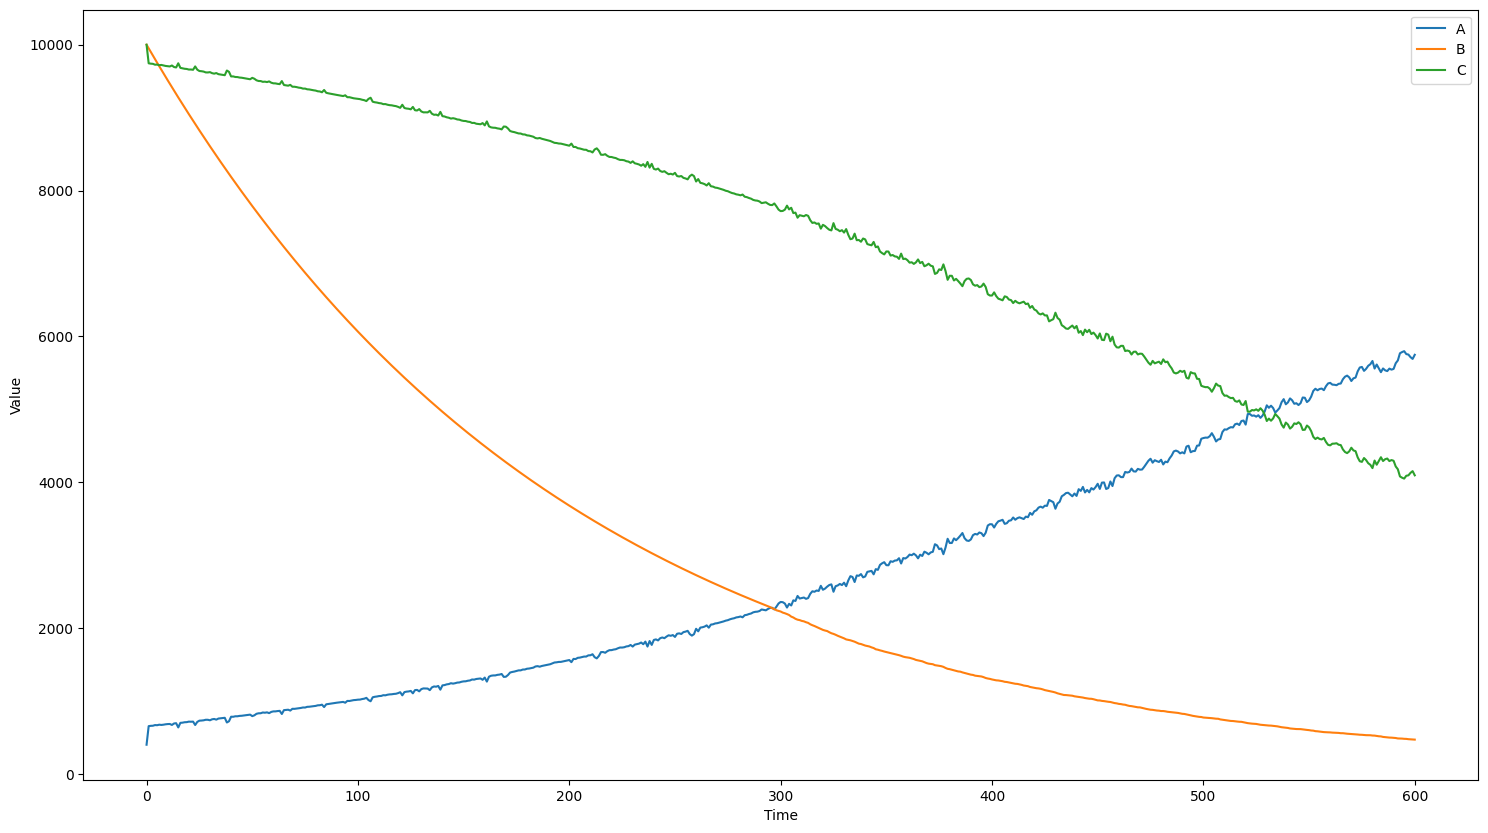

In [9]:
tau_hybrid_results.plot()

In [10]:
# Increase Tau and switching tolerance
for spec in model.listOfSpecies.values():
    spec.switch_tol = 0.05
    
%time results2 = model.run(solver=TauHybridSolver, tau_tol=0.04)

CPU times: user 20.2 s, sys: 107 ms, total: 20.3 s
Wall time: 34.1 s


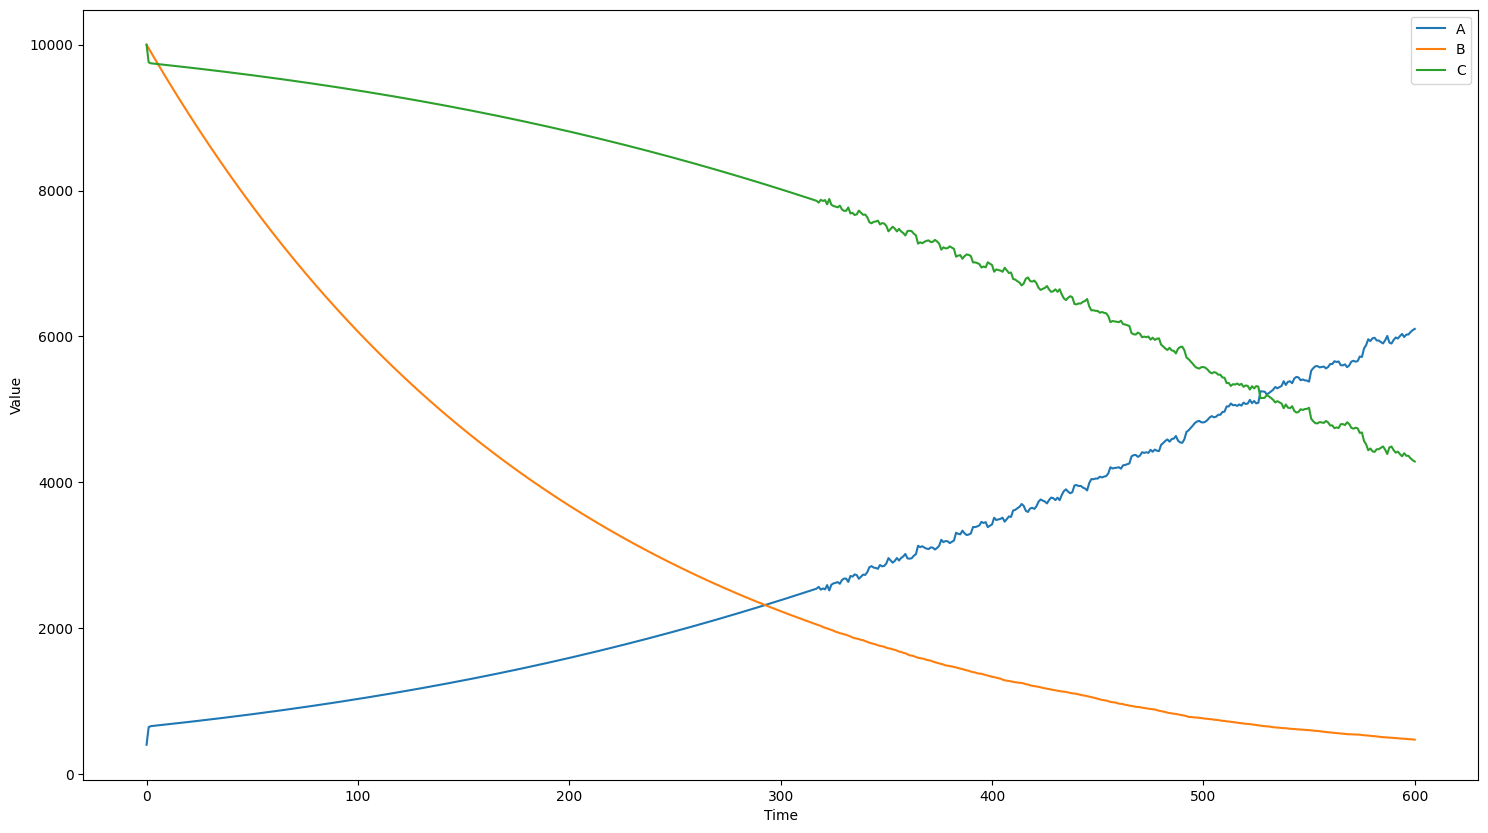

In [11]:
results2.plot()

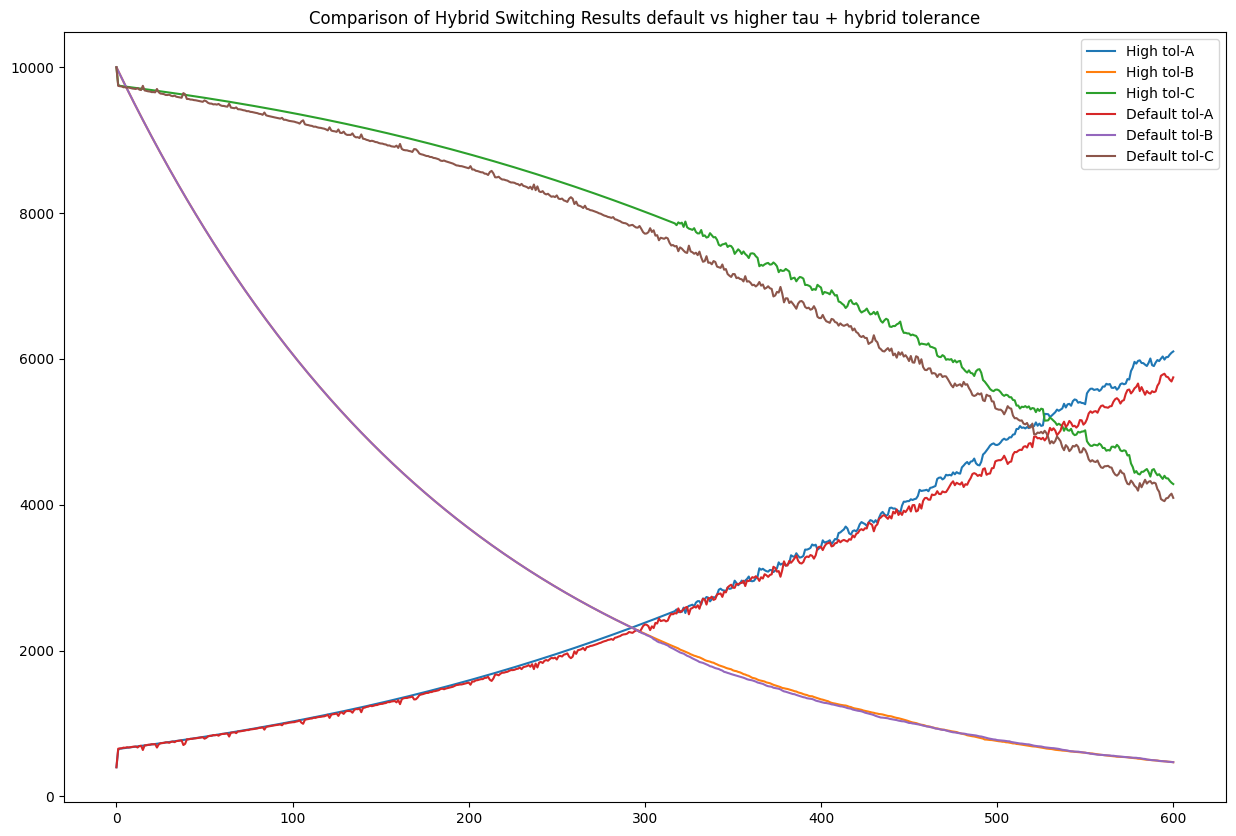

In [12]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results default vs higher tau + hybrid tolerance')
for species in results2[0]:
    if species == 'time': continue
    plt.plot(results2[0]['time'], results2[0][species], label='High tol-{0}'.format(species))
for species in tau_hybrid_results[0]:
    if species == 'time': continue
    plt.plot(tau_hybrid_results[0]['time'], tau_hybrid_results[0][species], label='Default tol-{0}'.format(species))
    plt.legend(loc='best')

In [13]:
%time results3 = model.run()

CPU times: user 25.9 s, sys: 100 ms, total: 26 s
Wall time: 38.4 s


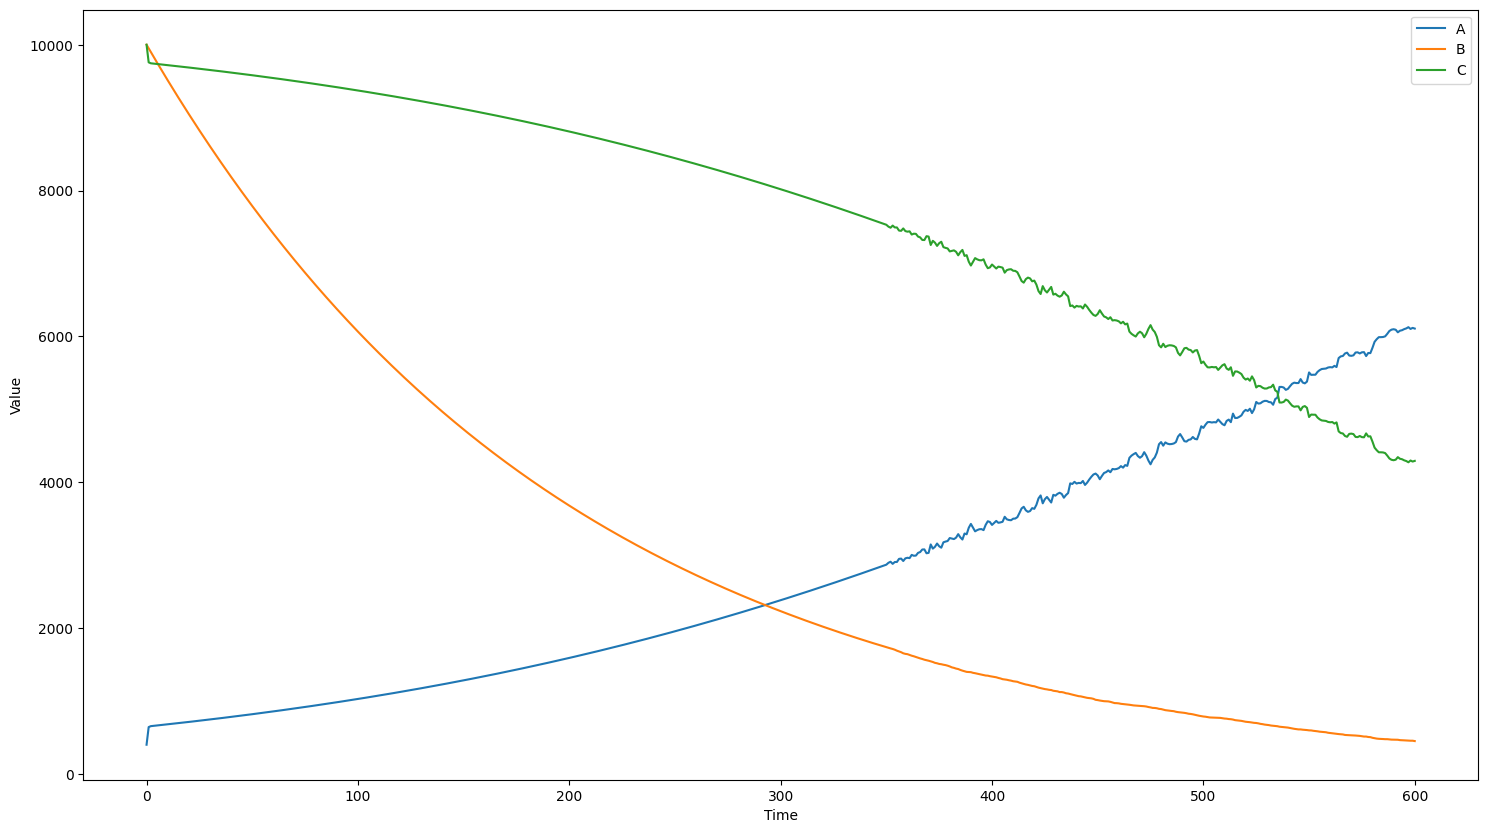

In [14]:
results3.plot()

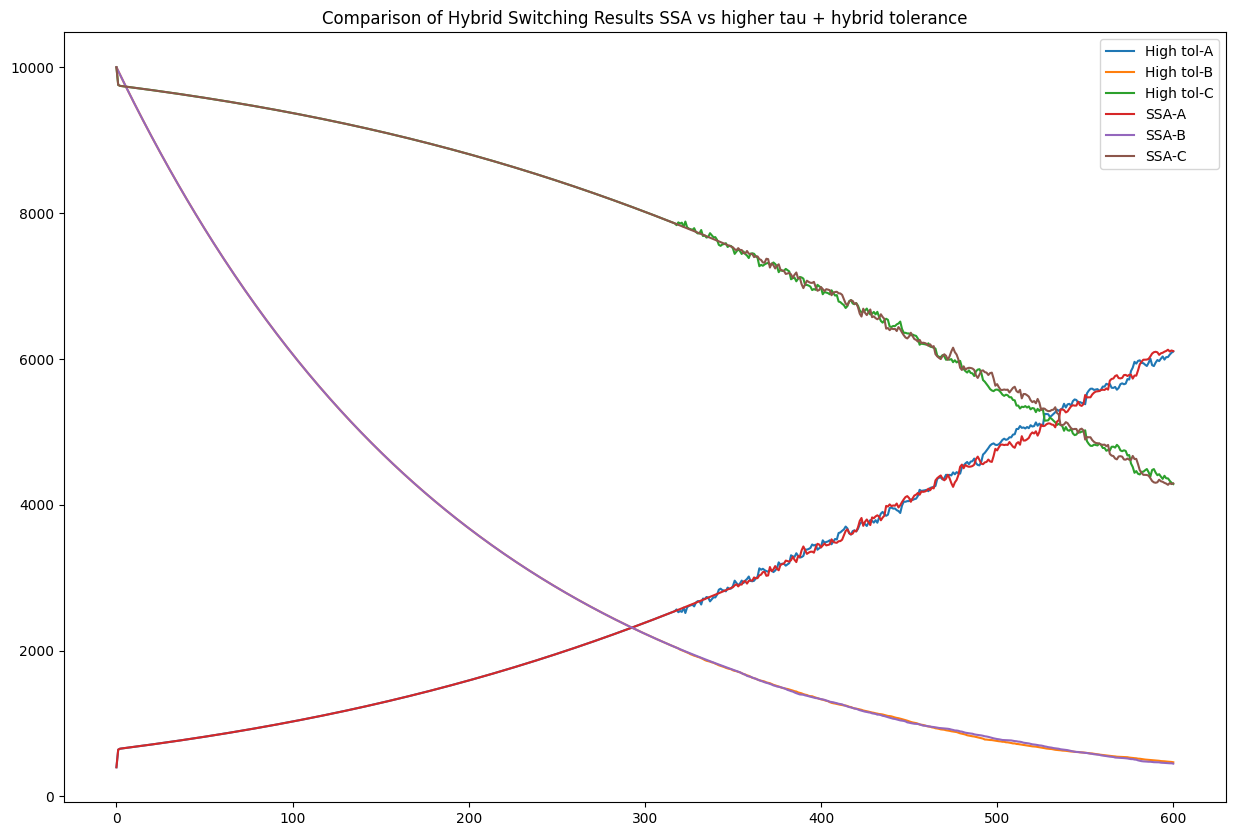

In [15]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results SSA vs higher tau + hybrid tolerance')
for species in results2[0]:
    if species == 'time': continue
    plt.plot(results2[0]['time'], results2[0][species], label='High tol-{0}'.format(species))
for species in results3[0]:
    if species == 'time': continue
    plt.plot(results3[0]['time'], results3[0][species], label='SSA-{0}'.format(species))
    plt.legend(loc='best')